In [1]:
# Import dependecies
import Pkg
Pkg.activate("psyc261")
Pkg.add("Plots")
Pkg.add("ProgressBars")
Pkg.add("Gen")
Pkg.add(["CSV", "DataFrames"])
Pkg.add("Distributions")
Pkg.add("HypothesisTests")
Pkg.add("GLM")
Pkg.add("Glob")
using Gen
using Glob
using ProgressBars
using Plots
using CSV
using DataFrames
using Distributions
using Statistics
using HypothesisTests
using Random
using GLM
include("utils/draw.jl")
;

  Activating project at `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261`
   Resolving package versions...
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Project.toml`
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Project.toml`
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Project.toml`
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Project.toml`
  No Changes to `/nfs/roberts/project/psyc2610/psyc2610_jen55/rhythm/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `

#### **Musical Scale Initialization**
The majority of this code is altered from Nguyen et al. (2025) by now encoding a note by its value and its position in a measure. My contributions in this code base are refactoring to include latent position, the design of the MLP to infer duration from latent position.

In [2]:
# A note is encoded by its value and its metrical position, P.
struct Note
    value::Float64
    position::Int64
end

# A scale is encoded by its key name and its internal notes.
struct MusicalScale
    name::Symbol
    notes::Vector{Note}
end

# For the time being, assume that we have exaclty 8 notes per measure.
MEASURE_LENGTH = 8

# A measure is encoded by the notes inside of it and its duration
latent_position(note::Note) = mod(note.position - 1, MEASURE_LENGTH) + 1
;

In [3]:
function create_scale(name::Symbol, root_note::Int, root_duration::Int, intervals::Vector{Int})
    notes = Note[]
    pos = 1
    for interval in intervals
        push!(notes, Note(root_note + interval, pos))
        pos = mod(pos + root_duration - 1, MEASURE_LENGTH) + 1
    end
    return MusicalScale(name, notes)
end

function create_major_scale(root_note::Int, root_duration::Int=8)
    MAJOR_INTERVALS = [0, 2, 4, 5, 7, 9, 11, 12]
    return create_scale(:major, root_note, root_duration, MAJOR_INTERVALS)
end

note_values(scale::MusicalScale) = [n.value for n in scale.notes]
note_positions(scale::MusicalScale) = [n.position for n in scale.notes]

function findnearest(value::Note, array::Vector{Note}, exclude=nothing)
    filtered = isnothing(exclude) ? array : filter(n -> n != exclude, array)
    idx = argmin(abs.(value.value .- [n.value for n in filtered]))
    return filtered[idx]
end
;

In [4]:
# I create some major scales for the model to draw from later on
C_NOTE = 60

C = create_major_scale(C_NOTE)
G = create_major_scale(55)  
D = create_major_scale(62)  
A = create_major_scale(57)  
E = create_major_scale(64)  
B = create_major_scale(59)  
F♯ = create_major_scale(66)
G♭ = create_major_scale(66)
D♭ = create_major_scale(61)
A♭ = create_major_scale(56)
E♭ = create_major_scale(63)
B♭ = create_major_scale(58)
F = create_major_scale(65)

major_scales = [C, G, D, A, E, B, F♯, G♭, D♭, A♭, E♭, B♭, F]
;

In [5]:
# Quick utility function to calculate duration
# signed, wrapped duration in beats, 0..(MEASURE_LENGTH-1)
function duration(note1::Note, note2::Note)
    return mod(note2.position - note1.position, MEASURE_LENGTH)
end
;
;

#### **Calculating musical forces**
I also need to create some functions to calculate the musical forces. All of these functions will take the key and current pitch (as an integer) as inputs and output to what extent each force should be applied given the position of the note in the scale (the degree), the position of the note in the measure, and the scale itself. These have to be changed to account for the new duration parameter, which breaks note subtraction.

In [6]:
function calculate_gravity(note::Note, key::MusicalScale)
    gravity_force = 0.0

    # Extract scale pitch values
    scale_values = [n.value for n in key.notes]

    # Find scale degree by pitch (not by struct equality)
    degree = findfirst(v -> v == note.value, scale_values)

    if degree !== nothing
        gravity_force = -0.05 * degree
    else
        nearest_stable_pitch = findnearest(note, key.notes)
        gravity_force = -0.05 * abs(note.value - nearest_stable_pitch.value)
    end

    return gravity_force
end
;

In [7]:
function calculate_magnetism(note::Note, key::MusicalScale)
    nearest = findnearest(note, key.notes)
    second_nearest = findnearest(note, key.notes, nearest)

    dto   = abs(note.value - nearest.value)
    dfrom = abs(note.value - second_nearest.value)

    magnetism_force = (1 / (dto^2 + 1)) - (1 / (dfrom^2 + 1))

    return magnetism_force
end
;

In [8]:
function calculate_inertia(note::Note, key::MusicalScale, tmp_sequence::Vector{Note})
    inertia_force = 0.0

    # Find scale degree by pitch
    scale_values = [n.value for n in key.notes]
    degree = findfirst(v -> v == note.value, scale_values)

    # Retrieve last note from sequence
    prev_note = tmp_sequence[end]

    if note.value > prev_note.value
        if degree !== nothing
            inertia_force = 0.5 * degree
        else
            inertia_force = 0.5
        end
    elseif note.value < prev_note.value
        if degree !== nothing
            inertia_force = -0.5 * degree
        else
            inertia_force = -0.5
        end
    end

    return inertia_force
end
;

Next, we create the rhythmic kernel for the scaling coefficients.

In [9]:
const DUR_TRANS = DataFrame(CSV.File("./data/temperley_training/bigram_data.csv"))
function normalize(v)
    s = sum(v)
    s == 0 ? fill(1/length(v), length(v)) : v ./ s
end

# Use 0-based positions internally
pos0(note::Note) = note.position - 1  # 0..7
Δt0(note1::Note, note2::Note) = mod(note2.position - note1.position, MEASURE_LENGTH)

const DUR_MAT = Array{Float64}(DUR_TRANS)
const DUR_COLS = [normalize(DUR_MAT[:, j] .+ 1e-5) for j in 1:size(DUR_MAT, 2)]

function get_empirical_probabilities(prev_pos0::Int, Δt0::Int)
    i = clamp(Δt0 + 1, 1, nrow(DUR_MAT))       # row
    j = clamp(prev_pos0 + 1, 1, ncol(DUR_MAT)) # col
    return DUR_MAT[i, j]
end
;

In [10]:
# Secondary hypothesis - can these be learned as a latent in the model too? TO DO LATER

In [11]:
@gen function rhythmic_kernel(curr_note::Note, tmp_sequence::Vector{Note})
    # Paper-ish baselines
    w_g0 = 1.0    # gravity
    w_m0 = 1.0    # magnetism
    w_i0 = 3.0    # inertia

    # --- base case: no history yet ---
    if isempty(tmp_sequence)
        # First note: no rhythmic context, just use baseline (or very mild noise)
        w_g = w_g0
        w_m = w_m0
        w_i = w_i0
        return (w_g, w_m, w_i)
    end

    # --- normal rhythmic context ---
    prev0 = pos0(tmp_sequence[end])                # 0-based previous position
    Δt0_  = Δt0(tmp_sequence[end], curr_note)      # 0-based Δt
    tprob = max(get_empirical_probabilities(prev0, Δt0_), 1e-6)

    # Map tprob ∈ (0,1] to an accent factor in [-1, 1]
    accent = clamp((tprob - 0.5) * 2, -1.0, 1.0)

    # Means for each weight:
    μ_g = w_g0 * (1 + 0.3 * accent)   # gravity: small effect
    μ_m = w_m0 * (1 + 0.8 * accent)   # magnetism: strong effect
    μ_i = w_i0 * (1 - 0.5 * accent)   # inertia: reduced on strong beats

    # Sample around these means with modest noise
    w_g ~ normal(μ_g, 0.1)
    w_m ~ normal(μ_m, 0.3)
    w_i ~ normal(μ_i, 0.2)

    return (w_g, w_m, w_i)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Note, Vector{Note}], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##rhythmic_kernel#292", Bool[0, 0], false)

In [12]:
@gen function melody_kernel(k::Int, curr_note::Note, key::MusicalScale, tmp_sequence::Vector{Note})
    σ = 0.5

    # Rhythmic scaling
    weights = @trace(rhythmic_kernel(curr_note, tmp_sequence), :rhythm)
    w_g, w_m, w_i = weights

    # Extend history safely
    new_sequence = [tmp_sequence...; curr_note]

    # Stochastic forces
    gravity   ~ normal(calculate_gravity(curr_note, key), σ)
    magnetism ~ normal(calculate_magnetism(curr_note, key), σ)
    inertia   ~ normal(calculate_inertia(curr_note, key, new_sequence), σ)

    # Combined force
    force = w_g * gravity + w_m * magnetism + w_i * inertia
    new_pitch = clamp(round(curr_note.value + force), 36, 96)

    # ---- ✅ Temperley-driven Δt ----
    # Temperley rows: 0–7 → model Δt: 1–8
    Δt_values = collect(0:(nrow(DUR_TRANS)-1))

    prev0 = pos0(curr_note)
    col   = clamp(prev0 + 1, 1, length(DUR_COLS))
    Δt_probs = DUR_COLS[col]

    Δt_idx = @trace(categorical(Δt_probs), :Δt_idx)
    Δt = Δt_values[Δt_idx]
    
    next_pos = mod(curr_note.position - 1 + Δt, MEASURE_LENGTH) + 1
    next_note = Note(new_pitch, next_pos)

    return next_note
end

chain = Gen.Unfold(melody_kernel)
;

Let's alter the example melody generation.

In [13]:
@gen function melody(K::Int, init_note=nothing, key=nothing)
    σ = 0.05

    # Track note history for inertia
    tmp_sequence = Note[]

    # Choose key
    key = @trace(draw(major_scales,
                      ones(length(major_scales)) / length(major_scales)),
                 :key)

    # Choose starting pitch around the middle of the of the distribution
    start = @trace(normal(key.notes[8].value, σ), :start)
    init_note = Note(round(start), 1)

    # Generate melodic sequence
    sequence ~ chain(K, init_note, key, tmp_sequence)

    return sequence
end
;

In [14]:
# TODO: debug tomorrow, rhythms are all just 1.
trace = Gen.simulate(melody, (10,)) 
get_retval(trace)

Persistent{Any}[Note(79.0, 7), Note(82.0, 3), Note(79.0, 3), Note(79.0, 3), Note(78.0, 3), Note(78.0, 3), Note(79.0, 3), Note(80.0, 3), Note(80.0, 3), Note(81.0, 3)]

In [15]:
get_choices(trace)

│
├── :key : MusicalScale(:major, Note[Note(66.0, 1), Note(68.0, 1), Note(70.0, 1), Note(71.0, 1), Note(73.0, 1), Note(75.0, 1), Note(77.0, 1), Note(78.0, 1)])
│
├── :start : 77.9798245710233
│
└── :sequence
    │
    ├── 1
    │   │
    │   ├── :magnetism : 0.3800403134754103
    │   │
    │   ├── :Δt_idx : 7
    │   │
    │   ├── :gravity : -0.4386923963208339
    │   │
    │   ├── :inertia : 0.2471383916288271
    │   │
    │   └── :rhythm
    │
    ├── 2
    │   │
    │   ├── :magnetism : 1.2231186522450084
    │   │
    │   ├── :Δt_idx : 5
    │   │
    │   ├── :gravity : 0.7686772573550753
    │   │
    │   ├── :inertia : 0.18770219695657664
    │   │
    │   └── :rhythm
    │
    ├── 3
    │   │
    │   ├── :magnetism : 0.28074420386348564
    │   │
    │   ├── :Δt_idx : 1
    │   │
    │   ├── :gravity : -0.6271049609709476
    │   │
    │   ├── :inertia : -0.8847259651856245
    │   │
    │   └── :rhythm
    │
    ├── 4
    │   │
    │   ├── :magnetism : 0.29482216210815876
  

#### **Particle Filtering**
(CHANGE THIS)
Next, I will implement a basic particle filter to better solve this inference problem. The structures of the following functions is intentionally tailored to the existing dataset that I have. A study by Morgan et al. (2019) asked participants to listen to a "melodic stem", a set of 6-9 notes that make the beginning of a melody, and sing what they think the last note should be. The purpose of my model is to output a similar end note to the human participants. First, I will create `make_observations` which creates a data frame from a vector of notes **and rhythms** and the key with gravity, magnetism, and inertia values at each time step. This data frame will be used to load observations into the particle filter. 

In [16]:
function make_observations(notes::Vector{Float64},
                           positions::Vector{Int64},
                           key::MusicalScale)

    # Build Note objects
    observed_notes = [Note(n, p) for (n, p) in zip(notes, positions)]

    # Broadcast gravity + magnetism correctly
    gravity   = calculate_gravity.(observed_notes, Ref(key))
    magnetism = calculate_magnetism.(observed_notes, Ref(key))

    # Sequential inertia
    inertia = Float64[]
    tmp_sequence = Note[]

    # Seed with initial note ONCE
    push!(tmp_sequence, init_note)
    
    for i in 1:length(observed_notes)
        tmp_inertia = calculate_inertia(observed_notes[i], key, tmp_sequence)
        push!(inertia, tmp_inertia)
        push!(tmp_sequence, observed_notes[i])
    end

    return DataFrame(
        obs_notes = observed_notes,
        gravity   = gravity,
        magnetism = magnetism,
        inertia   = inertia
    )
end
;

Let's alter the example melody sequence to incorporate a rhythmic component.

In [17]:
key = G
init_note = Note(62.0, 1)

# Observed notes and their rhythmic positions. Let's say we have a 4/4 measure.
# Actual last note is 67.
observed_note_values = [62.0, 59.0, 55.0, 62.0, 64.0, 60.0, 66.0, 62.0]

# observed_positions = [1, 3, 5, 7, 1, 3, 5, 7]
# Let's see what happens when we accelerate the melody
observed_positions = [1, 3, 5, 7, 5, 6, 7, 8]

obs_notes = make_observations(observed_note_values, observed_positions, key)
;

In [18]:
obs_notes

Row,obs_notes,gravity,magnetism,inertia
,Note,Float64,Float64,Float64
1,"Note(62.0, 1)",-0.25,0.8,0.0
2,"Note(59.0, 3)",-0.15,0.5,-1.5
3,"Note(55.0, 5)",-0.05,0.8,-0.5
4,"Note(62.0, 7)",-0.25,0.8,2.5
5,"Note(64.0, 5)",-0.3,0.8,3.0
6,"Note(60.0, 6)",-0.2,0.5,-2.0
7,"Note(66.0, 7)",-0.35,0.5,3.5
8,"Note(62.0, 8)",-0.25,0.8,-2.5


In [19]:
function particle_filter(
        num_particles::Int, 
        num_samples::Int, 
        key::MusicalScale, 
        obs_df::DataFrame,
        init_note::Note
    )

    # Initial observations
    init_obs = Gen.choicemap(
        (:key,   key),
        (:start, init_note.value)
    )

    # Initialize the particle filter
    state = Gen.initialize_particle_filter(melody, (0,), init_obs, num_particles)

    # Iterate over time steps
    for idx in 1:nrow(obs_df)

        # Resample if needed
        Gen.maybe_resample!(state, ess_threshold = num_particles / 2)

        # Load observations of this time step
        obs = Gen.choicemap(
            (:sequence => idx => :obs_gravity,   obs_df[idx, :gravity]),
            (:sequence => idx => :obs_magnetism, obs_df[idx, :magnetism]),
            (:sequence => idx => :inertia,       obs_df[idx, :inertia]),
            (:sequence => idx => :obs_note,      obs_df[idx, :obs_notes].value),
            (:sequence => idx => :obs_pos,       obs_df[idx, :obs_notes].position)
        )

        # Importance weight update
        Gen.particle_filter_step!(state, (idx,), (UnknownChange(),), obs)
    end

    # Return unweighted posterior samples
    return Gen.sample_unweighted_traces(state, num_samples)
end
;

In [20]:
Random.seed!(704)
pf_traces = particle_filter(2000, 200, key, obs_notes, init_note)

200-element Vector{Gen.DynamicDSLTrace}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], true, Union{Nothing, Some{Any}}[nothing, Some(nothing), Some(nothing)], var"##melody#294", Bool[0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:key => Gen.ChoiceOrCallRecord{MusicalScale}(MusicalScale(:major, Note[Note(55.0, 1), Note(57.0, 1), Note(59.0, 1), Note(60.0, 1), Note(62.0, 1), Note(64.0, 1), Note(66.0, 1), Note(67.0, 1)]), -2.5649493574615367, NaN, true), :sequence => Gen.ChoiceOrCallRecord{Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}}(Gen.VectorTrace{Gen.UnfoldType, Any, Gen.DynamicDSLTrace}(Unfold{Any, Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Note, MusicalScale, Vector{Note}], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing], var"##melody_kernel#293", Bool[0, 0, 0, 0], fal

In [21]:
# The value to beat is 69.225
last_notes = Note[]
for trace in pf_traces
    last_note = trace[:sequence][end]
    push!(last_notes, last_note)
end

pred_note_vals = [n.value for n in last_notes]
mu = mean(pred_note_vals)

69.815

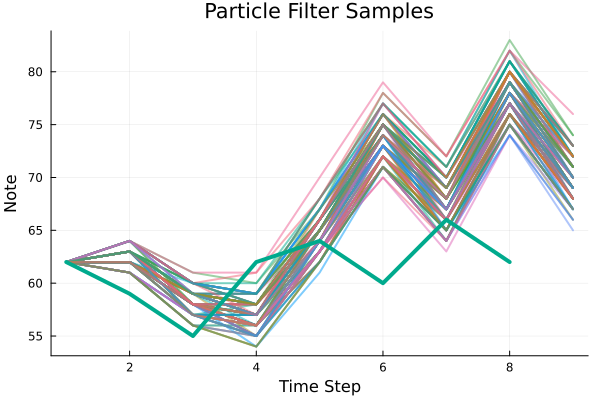

In [22]:
# Altering the visualize sample code
function visualize_samples(samples::Vector{Gen.DynamicDSLTrace},
                           obs_notes::Vector{Note})
    plot()
    for trace in samples
        sequence = Vector(trace[:sequence])
        pushfirst!(sequence, init_note)

        seq_vals = [n.value for n in sequence]
        plot!(seq_vals, linewidth=2, alpha=0.5, legend=false)
    end

    obs_vals = [n.value for n in obs_notes]
    plot!(obs_vals, linewidth=4, linestyle=:solid, label="Observed Sequence")

    xlabel!("Time Step")
    ylabel!("Note")
    title!("Particle Filter Samples")
    display(Plots.plot!())
end

init_note = Note(62.0, 1)

# Observed notes and their rhythmic positions. Let's say we have a 4/4 measure.
observed_note_values = [62.0, 59.0, 55.0, 62.0, 64.0, 60.0, 66.0, 62.0]
observed_positions = [1, 3, 5, 7, 1, 6, 7, 8]
observed_notes = [Note(n, p) for (n, p) in zip(observed_note_values, observed_positions)]

visualize_samples(pf_traces, observed_notes)

### **Experiment: Model vs Human Performance in Melodic and Rhythmic Expectation**

I have altered the method used to read CSV files from Nguyen et al. because I could not understand what the tops of each of the files meant. The files are encoding the note name and the rhythm, where the file name "X - KEY" denotes the melodic stem in the Morgan et al. (2018) dataset and the key of the excerpt.

In [23]:
const KEY_MAP = Dict(
    "C"  => C,
    "G"  => G,
    "D"  => D,
    "A"  => A,
    "E"  => E,
    "B"  => B,
    "F#" => F♯,
    "Gb" => G♭,
    "Db" => D♭,
    "Ab" => A♭,
    "Eb" => E♭,
    "Bb" => B♭,
    "F"  => F
)
const NOTE_TO_SEMITONE = Dict(
    "C"  => 0,
    "C#" => 1,  "Db" => 1,
    "D"  => 2,
    "D#" => 3,  "Eb" => 3,
    "E"  => 4,  "E#" => 5,
    "F"  => 5,
    "F#" => 6,  "Gb" => 6,
    "G"  => 7,
    "G#" => 8,  "Ab" => 8,
    "A"  => 9,
    "A#" => 10, "Bb" => 10,
    "B"  => 11
)
;

In [24]:
function extract_key(filename::String)
    key_with_ext = split(filename, " - ")[2]
    key, _ = splitext(key_with_ext)
    return key
end

function get_key_from_filename(filename::String)
    # Extract the key from the file name here
    key_str = extract_key(filename)
    return KEY_MAP[key_str]
end

function note_to_midi(note::AbstractString)::Float64
    m = match(r"^([A-G][#b]?)(-?\d+)$", note)
    m === nothing && error("Invalid note format: $note")

    pitch  = m.captures[1]
    octave = parse(Int, m.captures[2])

    semitone = NOTE_TO_SEMITONE[pitch]
    midi = (octave + 1) * 12 + semitone

    return Float64(midi)
end

function parse_music_csv(path::String)
    # The music CSVs come with both "AC" and "NC" stems to see how it works.
    df = CSV.read(path, DataFrame)

    df.AC = note_to_midi.(df.AC)
    df.NC = note_to_midi.(df.NC)

    return df
end
;

In [25]:
# We store AC and NC melodies and their respective endings in separate arrays
ac_melodies = Vector{Vector{Float64}}()
nc_melodies = Vector{Vector{Float64}}()
positions   = Vector{Vector{Int64}}() 
ac_endings  = Float64[]
nc_endings  = Float64[]
keys        = MusicalScale[]

for path in glob("data/nguyen_data/*.csv")
    key = get_key_from_filename(basename(path))
    df  = parse_music_csv(path)

    # All but last note
    push!(ac_melodies, df.AC[1:end-1])
    push!(nc_melodies, df.NC[1:end-1])
    push!(positions, df.Position[1:end-1])

    # Final note
    push!(ac_endings, df.AC[end])
    push!(nc_endings, df.NC[end])

    push!(keys, key)
end
;

In [26]:
function particle_mean_last_note(
    notes::Vector{Float64},
    positions::Vector{Int64},
    key;
    n_particles::Int = 500,
    horizon::Int = 200
)::Float64

    @assert !isempty(notes) "Empty melody passed to particle filter"

    obs = make_observations(notes, positions, key)
    traces = particle_filter(
        n_particles,
        horizon,
        key,
        obs,
        Note(notes[1], positions[1])     # initial note
    )

    @assert !isempty(traces) "Particle filter returned no traces"
    last_notes = Vector{Note}(undef, length(traces))

    for (j, trace) in enumerate(traces)
        seq = trace[:sequence]
        @assert !isempty(seq) "Empty sequence in trace $j"
        last_notes[j] = seq[end]
    end

    pred_note_vals = [n.value for n in last_notes]
    return mean(pred_note_vals)
end
;

In [27]:
Random.seed!(704)

num_melodies = length(ac_melodies)
ac_model_means = Vector{Float64}(undef, num_melodies)
nc_model_means = Vector{Float64}(undef, num_melodies)

for i in ProgressBar(1:num_melodies)
    ac_model_means[i] = particle_mean_last_note(ac_melodies[i], positions[i], keys[i])
    nc_model_means[i] = particle_mean_last_note(nc_melodies[i], positions[i], keys[i])
end
;

0.0%┣                                              ┫ 0/45 [00:01<00:-46, -1s/it]
2.2%┣█                                          ┫ 1/45 [00:02<Inf:Inf, InfGs/it]
4.4%┣██▏                                             ┫ 2/45 [00:02<01:36, 2s/it]
6.7%┣███▏                                            ┫ 3/45 [00:03<01:01, 1s/it]
8.9%┣████▎                                           ┫ 4/45 [00:04<00:49, 1s/it]
11.1%┣█████▏                                         ┫ 5/45 [00:04<00:43, 1s/it]
13.3%┣██████▎                                        ┫ 6/45 [00:05<00:39, 1it/s]
15.6%┣███████▎                                       ┫ 7/45 [00:06<00:35, 1it/s]
17.8%┣████████▍                                      ┫ 8/45 [00:06<00:32, 1it/s]
20.0%┣█████████▍                                     ┫ 9/45 [00:07<00:30, 1it/s]
22.2%┣██████████▏                                   ┫ 10/45 [00:07<00:28, 1it/s]
24.4%┣███████████▎                                  ┫ 11/45 [00:08<00:27, 1it/s]
26.7%┣████████████▎         

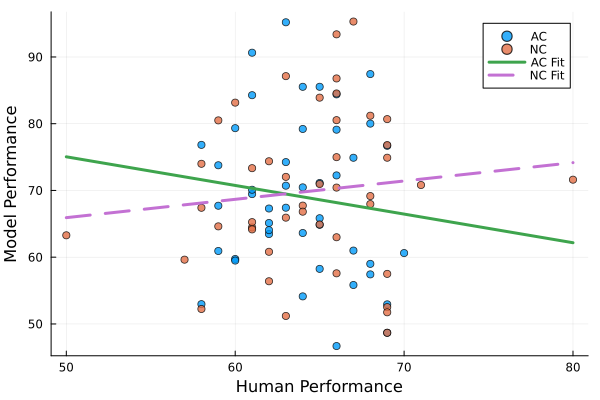

AC: r = -0.12208732912396116, R² = 0.014905315932622676, p = 0.4243277888124779
NC: r = 0.11737453163334426, R² = 0.01377678067614696, p = 0.4425612027482614


In [28]:
using Statistics, HypothesisTests, DataFrames, GLM, Plots

# --- Correlations ---
r_ac = cor(ac_endings, ac_model_means)
p_ac = pvalue(CorrelationTest(ac_endings, ac_model_means))

r_nc = cor(nc_endings, nc_model_means)
p_nc = pvalue(CorrelationTest(nc_endings, nc_model_means))

# --- DataFrames ---
df_ac = DataFrame(Y = Float64.(ac_model_means), x = Float64.(ac_endings))
df_nc = DataFrame(Y = Float64.(nc_model_means), x = Float64.(nc_endings))

# --- Regressions ---
line_ac = lm(@formula(Y ~ x), df_ac)
line_nc = lm(@formula(Y ~ x), df_nc)

rsq_ac = r2(line_ac)
rsq_nc = r2(line_nc)

# --- Scatter base ---
viz = scatter(
    df_ac.x, df_ac.Y,
    label = "AC",
    xlabel = "Human Performance",
    ylabel = "Model Performance",
    alpha = 0.8
)

scatter!(
    df_nc.x, df_nc.Y,
    label = "NC",
    alpha = 0.8
)

# --- Regression lines ---
x_vals = range(
    minimum(vcat(df_ac.x, df_nc.x)),
    maximum(vcat(df_ac.x, df_nc.x)),
    length = 200
)

y_ac = predict(line_ac, DataFrame(x = x_vals))
y_nc = predict(line_nc, DataFrame(x = x_vals))

plot!(x_vals, y_ac, linewidth = 3, label = "AC Fit")
plot!(x_vals, y_nc, linewidth = 3, linestyle = :dash, label = "NC Fit")

display(viz)

println("AC: r = $r_ac, R² = $rsq_ac, p = $p_ac")
println("NC: r = $r_nc, R² = $rsq_nc, p = $p_nc")